In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ga
import importlib
importlib.reload(ga)

from ga import *
from tradingrule import *

### Data preprocessing

In [3]:
data = pd.read_csv("data/AUDUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

,Open,High,Low,Close
0,0.70613,0.70613,0.70575,0.70575
1,0.70575,0.70579,0.70568,0.70579
2,0.70579,0.70598,0.70578,0.70595
3,0.70596,0.70618,0.70594,0.70618
4,0.70618,0.70628,0.70593,0.70595


In [4]:
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

In [5]:
%%time
trading_rule_params = trainTradingRuleFeatures(X_train)

Training Rule1 score is: 0.420
Training Rule2 score is: 0.420
Training Rule3 score is: 0.451
Training Rule4 score is: 0.422
Training Rule5 score is: 0.393
Training Rule6 score is: 0.446
Training Rule7 score is: 0.458
Training Rule8 score is: 0.370
Training Rule9 score is: 0.452
Training Rule10 score is: 0.460
Training Rule11 score is: 0.362
Training Rule12 score is: 0.457
Training Rule13 score is: 0.363
Training Rule14 score is: 0.240
Training Rule15 score is: 0.173
Training Rule16 score is: 0.119
CPU times: user 3min 12s, sys: 5.38 s, total: 3min 18s
Wall time: 3min 5s


In [6]:
%%time
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

CPU times: user 3.7 s, sys: 31 ms, total: 3.73 s
Wall time: 3.66 s


### Genetic Algorithm to Find the Optimal Combination of Rules

In [7]:
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))

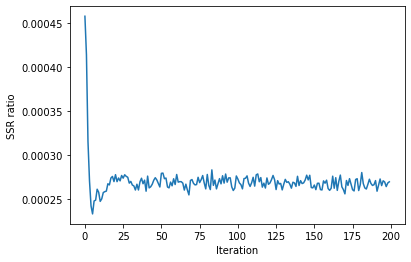

CPU times: user 34.1 s, sys: 2.13 s, total: 36.2 s
Wall time: 36.2 s


In [8]:
%%time
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

In [9]:
position = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position /= np.max(abs(position))
print('Training data evaluation:')
evaluate(position, X_trading_rule_train.logr)
port_r_train = X_trading_rule_train.logr*position

Training data evaluation:
The maximum position is 0.916, the mean postiion is 0.512516.
The return over the period is: 28.01%
Maximum drawdown is: -1.234%
SR ratio is: 8.914


In [10]:
position = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position /= np.max(abs(position))
print('Testing data evaluation:')
evaluate(position, X_trading_rule_test.logr)
port_r_test = X_trading_rule_test.logr*position

Testing data evaluation:
The maximum position is 0.797, the mean postiion is 0.490399.
The return over the period is: 13.97%
Maximum drawdown is: -0.194%
SR ratio is: 5.810


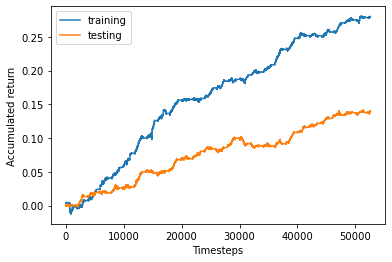

In [11]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.show()